## Random Forest Classifier: validate with results from combinatorial screens

**Input**:
* Our training dataset of (non-)SL paralog pairs + all features
* Consensuns and independent data sets of (non-)SL paralog pairs from combinatorial screens

**Output**: Random Forest model (pickle)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import itertools
import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs (training data and features)
file_feature_list = get_local_data_path([],'feature_list.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')

# Inputs (validation data)
file_thompson_pairs = get_local_data_path(['processed', 'screen_pairs'], 'thompson_pairs.csv')
file_dede_pairs = get_local_data_path(['processed', 'screen_pairs'], 'dede_pairs.csv')
file_parrish_pairs = get_local_data_path(['processed','screen_pairs'], 'parrish_pairs.csv')
file_chymera_pairs = get_local_data_path(['processed','screen_pairs'], 'chymera_pairs_filtered.csv')
file_all_screened_pairs = get_local_data_path(['processed', 'screen_pairs'], 'all_screened_pairs.csv')
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')

# Output
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')

### Training & Testing Data

#### Training data + feature annotations for all paralog pairs

In [2]:
all_paralog_annotations = pd.read_csv(file_annot_pairs, float_precision="round_trip")
print('Num annotated paralog pairs:', all_paralog_annotations.shape[0])
all_paralog_annotations[:1]

Num annotated paralog pairs: 36648


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,A1BG_OSCAR,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,...,False,False,False,False,3,210.95,0.0,False,False,False


In [3]:
features = pd.read_csv(file_feature_list).feature.values.tolist()
print('N features:', len(features))

N features: 22


In [4]:
depmap_pairs = pd.read_csv(file_depmap_pairs)
# Note this sorting is important for exact reproducible training of the classifier
depmap_pairs = pd.merge(depmap_pairs, all_paralog_annotations).sort_values(['A1','A2']).reset_index(drop=True)
print('N SL:', depmap_pairs[depmap_pairs.SL].shape[0], '/', depmap_pairs.shape[0])
depmap_pairs[:1]

N SL: 126 / 3634


,sorted_gene_pair,SL,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,AAK1_BMP2K,False,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,...,False,False,False,False,7,976.25,0.0,False,True,False


#### Validation data - results from independent combinatorial screens

In [5]:
all_thompson_pairs = pd.read_csv(file_thompson_pairs)
all_thompson_pairs = pd.merge(all_thompson_pairs[all_thompson_pairs.passes_min_1_filter], all_paralog_annotations)
all_thompson_pairs['SL'] = all_thompson_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
thompson_pairs = all_thompson_pairs[(all_thompson_pairs.n_SL>=2) | (all_thompson_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_thompson_pairs.SL), '/', all_thompson_pairs.shape[0])
print('For 2+ vs. 0:', sum(thompson_pairs.SL), '/', thompson_pairs.shape[0])
thompson_pairs[:1]

All: 71 / 475
For 2+ vs. 0: 23 / 427


,sorted_gene_pair,A375_SL,Mewo_SL,RPE_SL,n_SL,passes_min_1_filter,passes_A375_filter,passes_Mewo_filter,passes_RPE_filter,in_93,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,SL
0,CASKIN1_CASKIN2,False,False,False,0,True,True,False,True,True,...,False,False,False,6,842.0,0.0,False,True,False,False


In [6]:
all_dede_pairs = pd.read_csv(file_dede_pairs)
all_dede_pairs = pd.merge(all_dede_pairs, all_paralog_annotations)
all_dede_pairs['SL'] = all_dede_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
dede_pairs = all_dede_pairs[(all_dede_pairs.n_SL>=2) | (all_dede_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_dede_pairs.SL), '/', all_dede_pairs.shape[0])
print('For 2+ vs. 0:', sum(dede_pairs.SL), '/', dede_pairs.shape[0])
dede_pairs[:1]

All: 24 / 393
For 2+ vs. 0: 19 / 388


,sorted_gene_pair,A549,HT29,OVCAR8,A549_SL,HT29_SL,OVCAR8_SL,n_SL,in_93,in_102,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,SL
0,ABHD4_ABHD5,-0.609,-0.036,-0.046,False,False,False,0,True,True,...,True,False,False,8,994.6,0.0,False,True,False,False


In [7]:
all_parrish_pairs = pd.read_csv(file_parrish_pairs)
all_parrish_pairs = pd.merge(all_parrish_pairs, all_paralog_annotations)
all_parrish_pairs['SL'] = all_parrish_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
parrish_pairs = all_parrish_pairs[(all_parrish_pairs.n_SL>=2) | (all_parrish_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_parrish_pairs.SL), '/', all_parrish_pairs.shape[0])
print('For 2+ vs. 0:', sum(parrish_pairs.SL), '/', parrish_pairs.shape[0])
parrish_pairs[:1]

All: 122 / 1027
For 2+ vs. 0: 35 / 940


,sorted_gene_pair,PC9_SL,HeLa_SL,n_SL,in_93,in_102,A1,A2,A1_ensembl,A2_ensembl,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,SL
0,A2M_PZP,False,False,0,True,True,A2M,PZP,ENSG00000175899,ENSG00000126838,...,False,False,True,5,454.6,0.0,False,False,False,False


In [8]:
all_chymera_pairs = pd.read_csv(file_chymera_pairs)
all_chymera_pairs = pd.merge(all_chymera_pairs, all_paralog_annotations)
all_chymera_pairs['SL'] = all_chymera_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
chymera_pairs = all_chymera_pairs[(all_chymera_pairs.n_SL>=2) | (all_chymera_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_chymera_pairs.SL), '/', all_chymera_pairs.shape[0])
print('For 2+ vs. 0:', sum(chymera_pairs.SL), '/', chymera_pairs.shape[0])
chymera_pairs[:1]

All: 72 / 658
For 2+ vs. 0: 10 / 596


,sorted_gene_pair,hap1_SL,rpe1_SL,n_SL,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,SL
0,SEC23A_SEC23B,True,True,2,SEC23A,SEC23B,ENSG00000100934,ENSG00000101310,10484,10483,...,True,False,False,8,1628.0,0.5,True,True,False,True


#### Consensus pairs
TPs = Paralog pairs found to be hits in at least two studies (Dede/Thompson/Parrish/Chymera)  
TNs = Pairs screened in at least two studies and not found to be hits in any study

In [9]:
all_screened_pairs = pd.read_csv(file_all_screened_pairs)
all_screened_pairs['SL'] = (all_screened_pairs.n_screens_SL >= 1) 
print('N pairs screened in at least 1 study:', sum(all_screened_pairs.SL), '/', all_screened_pairs.shape[0])
all_screened_pairs = pd.merge(all_screened_pairs, all_paralog_annotations)
all_screened_pairs[:1]

N pairs screened in at least 1 study: 224 / 1845


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL,A1,A2,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,False,CASKIN1,CASKIN2,...,False,False,False,False,6,842.0,0.0,False,True,False


In [10]:
consensus = pd.read_csv(file_consensus_pairs)
print('Consensus data set: %d/%d = %.2f%%' % (sum(consensus.SL), consensus.shape[0], sum(consensus.SL)/consensus.shape[0]*100))
consensus = pd.merge(consensus, all_paralog_annotations)
consensus[:1]

Consensus data set: 50/457 = 10.94%


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL,A1,A2,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,False,CASKIN1,CASKIN2,...,False,False,False,False,6,842.0,0.0,False,True,False


### Drawing code for ROC/PR curves

In [11]:
def draw_roc_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True, nums_only=False, fontsize=9):
    fpr, tpr, _ = roc_curve(data.SL, ypred)
    line_kwargs = {"drawstyle":"steps-post"}
    rf_label = label+'(%.2f)' % (auc(fpr, tpr))
    if nums_only: rf_label = '%.2f' % (auc(fpr, tpr))
    ax.step(fpr, tpr, label=rf_label, color=color, zorder=10, **line_kwargs)    
    if w_seq:
        fpr_seq_id, tpr_seq_id, _ = roc_curve(data.SL, data.min_sequence_identity)
        seq_label = 'Seq. Id. (%.2f)' % (auc(fpr_seq_id, tpr_seq_id))
        if nums_only: seq_label = '%.2f' % (auc(fpr_seq_id, tpr_seq_id))
        ax.step(fpr_seq_id, tpr_seq_id, label=seq_label, color='#E69F00', **line_kwargs)
    if w_chance:
        chance_label = 'Chance (0.50)'
        if nums_only: chance_label = '0.50'
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', label=chance_label)
        ax.legend(loc="lower right", fontsize=fontsize) # bbox_to_anchor=(1.08,0)
    ax.set_xlabel('False Positive Rate', fontsize=fontsize); ax.set_ylabel('True Positive Rate', fontsize=fontsize)
    ax.set_ylim([-0.05,1.01]); ax.set_xlim([-0.05,1])

def draw_pr_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True, trim=False, nums_only=False,
                  fontsize=9):
    precision, recall, _ = precision_recall_curve(data.SL, ypred)
    if trim: precision = precision[:-1]; recall = recall[:-1]
    avg_precision = average_precision_score(data.SL, ypred)
    line_kwargs = {"drawstyle":"steps-post"}
    rf_label = label+'(%.2f)' % (avg_precision)
    if nums_only: rf_label = '%.2f' % (avg_precision)
    ax.plot(recall, precision, label=rf_label, color=color, **line_kwargs, zorder=10)
    if w_seq:
        precision_seq_id, recall_seq_id, _ = precision_recall_curve(data.SL, data.min_sequence_identity)
        recall_seq_id = recall_seq_id[:-1]; precision_seq_id = precision_seq_id[:-1]
        ap_seq_id = average_precision_score(data.SL,  data.min_sequence_identity)
        seq_label = 'Seq. Id. (%.2f)' % (ap_seq_id)
        if nums_only: seq_label = '%.2f' % (ap_seq_id)
        ax.plot(recall_seq_id, precision_seq_id, label=seq_label, color='#E69F00', **line_kwargs)
    if w_chance:
        no_skill = sum(data.SL) / (data.SL).count()
        chance_label = 'Chance (%.2f)' % (no_skill)
        if nums_only: chance_label = '%.2f' % (no_skill)
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label=chance_label)
        ax.legend(loc="upper right", fontsize=fontsize) # bbox_to_anchor=(1.1,1)
    ax.set_xlabel('Recall', fontsize=fontsize); ax.set_ylabel('Precision', fontsize=fontsize)
    ax.set_ylim([-0.05,1.01]); ax.set_xlim([-0.05,1])
    
def draw_curves(data, ypred, screen, n_SL, ax, trim=True, title='', fontsize=9):
    draw_roc_curve(data, ypred, ax[0], label='RF ', fontsize=fontsize)
    draw_pr_curve(data, ypred, ax[1], label='RF ', trim=trim, fontsize=fontsize)
    if title=='':
        f.suptitle(screen+' screens, SL in '+n_SL+' cell lines (SL='+str(sum(data.SL))+', non-SL='+str(sum(~data.SL))+')', 
                   fontsize=fontsize, fontweight='bold', horizontalalignment='center')
    else:
        f.suptitle(title, fontsize=fontsize, fontweight='bold', horizontalalignment='center')
    plt.tight_layout()

### Train Classifier

In [12]:
RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.5, max_depth=3, min_samples_leaf=8)
_ = RF.fit(depmap_pairs[features], depmap_pairs.SL)

In [13]:
with open(file_RF_model, 'wb') as f:
    pickle.dump(RF, f)

In [18]:
# Can also just load model from file
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

### Validation with consensus from the 4 combinatorial screens

Min threshold for >=50% precision 0.2594913760178888
Max recall for >=50% precision 0.32


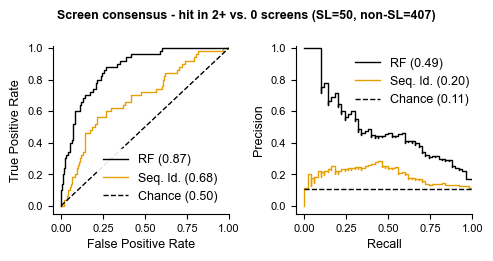

In [14]:
ypred = RF.predict_proba(consensus[features])[:,1]
P, R, thresholds = precision_recall_curve(consensus.SL, ypred)
print('Min threshold for >=50% precision', thresholds[np.argwhere((P >= 0.5) & (P != 1)).min()])
print('Max recall for >=50% precision', R[np.argwhere((P >= 0.5) & (P != 1)).min()])

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(consensus, ypred, '', '', ax, trim=False, title=('Screen consensus - hit in 2+ vs. 0 screens (SL='+
                                                             str(sum(consensus.SL))+', non-SL='+str(sum(~consensus.SL))+')'))
#ax[0].legend(loc="lower right", bbox_to_anchor=(1.1,0), fontsize=9)
ax[1].legend(loc="upper right", bbox_to_anchor=(1.05,1), fontsize=9)
plt.tight_layout()
plt.savefig("../figures/for_paper/consensus_roc_pr.svg", dpi=300)

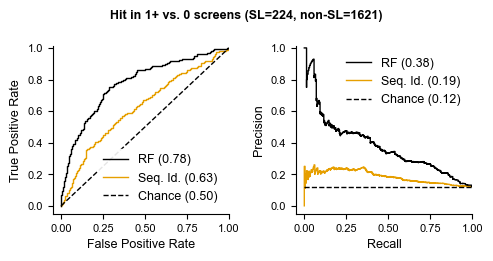

In [15]:
ypred = RF.predict_proba(all_screened_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(all_screened_pairs, ypred, '', '', ax, trim=False, 
            title=('Hit in 1+ vs. 0 screens (SL='+str(sum(all_screened_pairs.SL))+
                   ', non-SL='+str(sum(~all_screened_pairs.SL))+')'))
plt.tight_layout()
plt.savefig("../figures/for_paper/any_hit_roc_pr.svg", dpi=300)

#### Unseen pairs only

Max recall for >=50% precision 0.2727272727272727


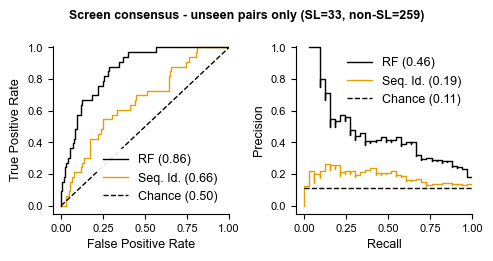

In [16]:
# Drop all overlapping pairs
test_pairs = pd.merge(depmap_pairs[['A1','A2']], consensus, how='right', indicator='in_broad')
test_pairs = test_pairs[test_pairs.in_broad!='both']
ypred = RF.predict_proba(test_pairs[features])[:,1]
P, R, thresholds = precision_recall_curve(test_pairs.SL, ypred)
print('Max recall for >=50% precision', R[np.argwhere((P >= 0.5) & (P != 1)).min()])

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(test_pairs, ypred, '', '', ax, title=('Screen consensus - unseen pairs only (SL='+
                                                  str(sum(test_pairs.SL))+', non-SL='+str(sum(~test_pairs.SL))+')'))
plt.tight_layout()
f.savefig("../figures/for_paper/consensus_unseen_roc_pr.svg", bbox_inches="tight", dpi=300)

Max recall for >=50% precision 0.0979020979020979


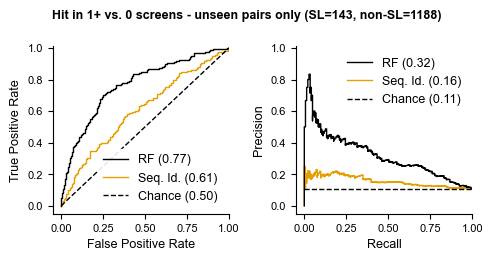

In [17]:
# Drop all overlapping pairs
test_pairs = pd.merge(depmap_pairs[['A1','A2']], all_screened_pairs, how='right', indicator='in_broad')
test_pairs = test_pairs[test_pairs.in_broad!='both'].reset_index(drop=True)
ypred = RF.predict_proba(test_pairs[features])[:,1]
P, R, thresholds = precision_recall_curve(test_pairs.SL, ypred)
print('Max recall for >=50% precision', R[np.argwhere((P >= 0.5) & (P != 1)).min()])

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(test_pairs, ypred, '', '', ax, title=('Hit in 1+ vs. 0 screens - unseen pairs only (SL='+
                                                  str(sum(test_pairs.SL))+', non-SL='+str(sum(~test_pairs.SL))+')'))
plt.tight_layout()
f.savefig("../figures/for_paper/any_hit_unseen_roc_pr.svg", bbox_inches="tight", dpi=300)

### Individual combinatorial screens

In [18]:
def draw_subplot_title(nhits, data, x):
    f.text(x, 0.86, 'Hit in '+nhits+' cell lines (SL='+str(sum(data.SL))+', non-SL='+str(sum(~data.SL))+')', fontsize=9)

def draw_plot_quartet(pairs_min2, pairs_min1, ax, trim=True):
    ypred = RF.predict_proba(pairs_min2[features])[:,1]
    draw_roc_curve(pairs_min2, ypred, ax[0], nums_only=True)
    draw_pr_curve(pairs_min2, ypred, ax[1], trim=trim, nums_only=True)
    draw_subplot_title('2+ vs. 0', pairs_min2, 0.12)

    ypred = RF.predict_proba(pairs_min1[features])[:,1]
    draw_roc_curve(pairs_min1, ypred, ax[2], nums_only=True)
    draw_pr_curve(pairs_min1, ypred, ax[3], trim=trim, nums_only=True)
    draw_subplot_title('1+ vs. 0', pairs_min1, 0.6)

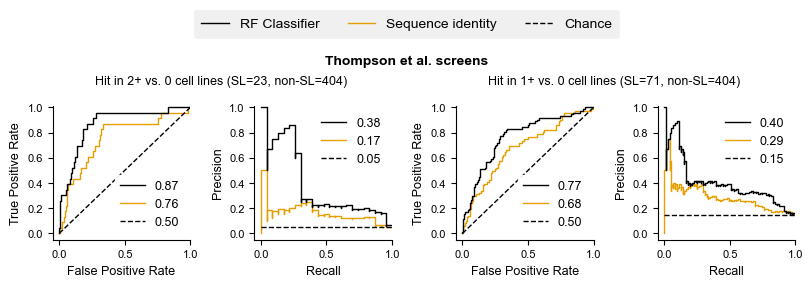

In [19]:
f, ax = plt.subplots(1, 4, figsize=(8.2,2.4))
draw_plot_quartet(thompson_pairs, all_thompson_pairs, ax, trim=False)
f.suptitle('Thompson et al. screens\n', fontsize=10, fontweight='bold')
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles=handles, labels=['RF Classifier', 'Sequence identity', 'Chance'], ncol=3, loc='upper center', 
         bbox_to_anchor=[0.5,1.2], fontsize=10, fancybox=True, facecolor='#efefef', borderpad=0.6)
plt.tight_layout()
f.savefig("../figures/for_paper/thompson_roc_pr.svg", bbox_inches="tight", dpi=300)

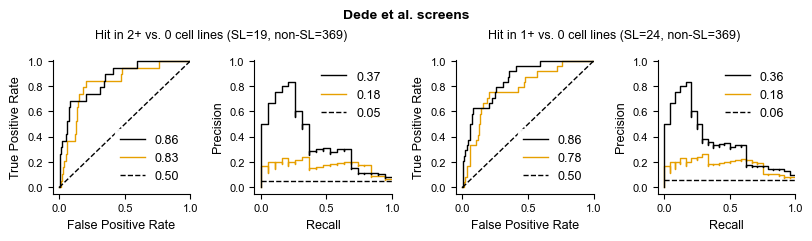

In [20]:
f, ax = plt.subplots(1, 4, figsize=(8.2,2.4))
draw_plot_quartet(dede_pairs, all_dede_pairs, ax)
f.suptitle('Dede et al. screens\n', fontsize=10, fontweight='bold')
plt.tight_layout()
f.savefig("../figures/for_paper/dede_roc_pr.svg", bbox_inches="tight", dpi=300)

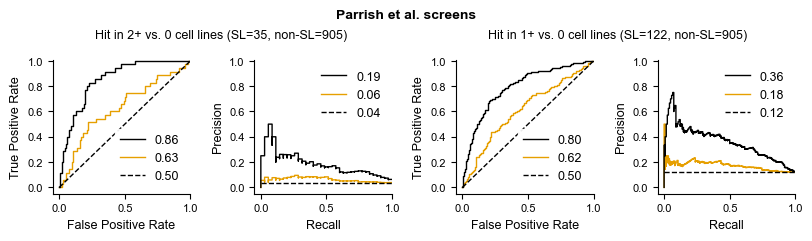

In [21]:
f, ax = plt.subplots(1, 4, figsize=(8.2,2.4))
draw_plot_quartet(parrish_pairs, all_parrish_pairs, ax)
f.suptitle('Parrish et al. screens\n', fontsize=10, fontweight='bold')
plt.tight_layout()
f.savefig("../figures/for_paper/parrish_roc_pr.svg", bbox_inches="tight", dpi=300)

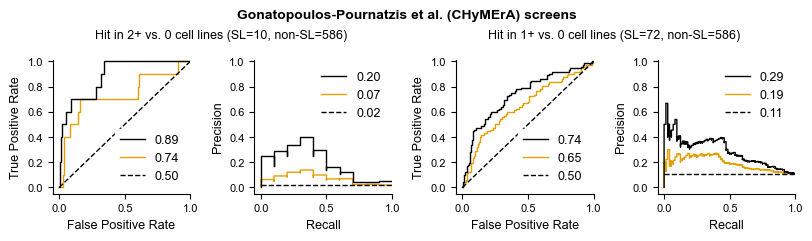

In [22]:
f, ax = plt.subplots(1, 4, figsize=(8.2,2.4))
draw_plot_quartet(chymera_pairs, all_chymera_pairs, ax)
f.suptitle('Gonatopoulos-Pournatzis et al. (CHyMErA) screens\n', fontsize=10, fontweight='bold')
plt.tight_layout()
f.savefig("../figures/for_paper/chymera_roc_pr.svg", bbox_inches="tight", dpi=300)